In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import xmltodict
import base64
import numpy as np
import array

from sklearn.metrics import accuracy_score,precision_score, recall_score
from IPython.display import clear_output

# Data Preprocessings

In [2]:
def get_lead(path):
    with open(path, 'rb') as xml:
        ECG = xmltodict.parse(xml.read().decode('utf8'))
    
    augmentLeads = True
    if path.split('/')[-1][0] == '5':
        waveforms = ECG['RestingECG']['Waveform'][1]
    elif path.split('/')[-1][0] == '6':
        waveforms = ECG['RestingECG']['Waveform']
        augmentLeads = False
    else:
        waveforms = ECG['RestingECG']['Waveform']
    
    leads = {}
    
    for lead in waveforms['LeadData']:
        lead_data = lead['WaveFormData']
        lead_b64  = base64.b64decode(lead_data)
        lead_vals = np.array(array.array('h', lead_b64))
        leads[ lead['LeadID'] ] = lead_vals
    
    if augmentLeads:
        leads['III'] = np.subtract(leads['II'], leads['I'])
        leads['aVR'] = np.add(leads['I'], leads['II'])*(-0.5)
        leads['aVL'] = np.subtract(leads['I'], 0.5*leads['II'])
        leads['aVF'] = np.subtract(leads['II'], 0.5*leads['I'])
    
    return leads

In [3]:
error_train = ['6_2_003469_ecg.xml', '6_2_003618_ecg.xml', '6_2_005055_ecg.xml', '8_2_001879_ecg.xml', '8_2_002164_ecg.xml']
error_valid = ['8_2_007281_ecg.xml', '8_2_008783_ecg.xml', '8_2_007226_ecg.xml']


train_data = []
train_labels = []
valid_data = []
valid_labels = []


train_pathes = ['data/train/arrhythmia/', 'data/train/normal/']
valid_pathes = ['data/validation/arrhythmia/', 'data/validation/normal/']

error_decode = []   # 디코딩에 실패한 데이터들..
# error_len = [] # 5000, 4999개를 맞추지 못한 데이터들.. 혹은 12개의 lead가 아닌것들..

# train data
for path in train_pathes:
    for file in os.listdir(path):
        
        if file in error_train:
            print(file)
            continue
        
        try:
            data = get_lead(path + file)
        except Exception as e:
            error_decode.append(path + file)
        
        listed_data = []
        keys = sorted(data.keys())
        for key in keys:
            listed_data.append(data[key])
        
        flag = False
        for idx, i in enumerate(listed_data):
            if len(i) == 5000:
                continue
            elif len(i) == 4999:
                listed_data[idx] = np.append(i, 0)
            else:
                flag = True
        if flag:
            continue
        
        train_data.append(listed_data)
        if 'arrhythmia' in path:
            train_labels.append(1)
        else:
            train_labels.append(0)
            
# valid data
for path in valid_pathes:
    for file in os.listdir(path):
        
        if file in error_valid:
            print(file)
            continue
            
        try:
            data = get_lead(path + file)
        except Exception as e:
            error_decode.append(path + file)
        
        listed_data = []
        keys = sorted(data.keys())
        for key in keys:
            listed_data.append(data[key])
        
        valid_data.append(listed_data)
        if 'arrhythmia' in path:
            valid_labels.append(1)
        else:
            valid_labels.append(0)

print(len(error_decode))


6_2_003469_ecg.xml
8_2_001879_ecg.xml
6_2_003618_ecg.xml
8_2_002164_ecg.xml
6_2_005055_ecg.xml
8_2_007281_ecg.xml
8_2_008783_ecg.xml
8_2_007226_ecg.xml
8


In [4]:
error_lead_len = []
for idx, i in enumerate(train_data):
    if len(i) != 12:
        error_lead_len.append(idx)
for i in error_lead_len:
    del train_data[i]
    del train_labels[i]
    

# 데이터 길이 및 lead 개수 분석

In [5]:
# 데이터의 길이 분포 확인: valid는 모두 5000인것을 확인
# train은 60912개가 4999, 36개가 1249, 1개가 4988
# 위의 테스크는 먼저 4999개만 0의 패딩을 붙이고 나머지는 제외하는식으로 전처리함

c4999 = 0
c5000 = 0
cx = 0

for i in train_data:
    for j in i:
        if len(j) == 4999:
            c4999 +=1
        elif len(j) == 5000:
            c5000 +=1
        else:
            cx +=1

for i in valid_data:
    for j in i:
        if len(j) == 4999:
            c4999 +=1
        elif len(j) == 5000:
            c5000 +=1
        else:
            cx +=1

print(c4999)
print(c5000)
print(cx)

0
524436
0


In [6]:
# 딱 한개의 9 lead의 데이터가 존재한다..
v12 = 0
v9 = 0
vx = 0

for i in train_data:
    if len(i) == 12:
        v12 +=1
    elif len(i) == 9:
        v9 += 1
    else:
        vx +=1
        
for i in valid_data:
    if len(i) == 12:
        v12 +=1
    elif len(i) == 9:
        v9 += 1
    else:
        vx +=1
print(v12)
print(v9)
print(vx)

43703
0
0


# Dataset 생성

In [7]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(valid_data).float(), torch.tensor(valid_labels))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [8]:
# residual과 dropout 추가 필요
class Classifier(nn.Module):
    def __init__(self, drop_out=0.0):
        super(Classifier,self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, padding=2) 
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
    
        self.pool1 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(5)
        self.pool3 = nn.MaxPool1d(5)
        
    
        self.fc1 = nn.Linear(64 * 50, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        
        self.drop_out = nn.Dropout(p=drop_out)
        
        
    def forward(self, x):
        x = self.relu(self.cnn1(x))
        x = self.pool1(x)
        x = self.relu(self.cnn2(x))
        x = self.pool2(x)
        x = self.relu(self.cnn3(x))
        x = self.pool3(x)

        x = x.view(-1, 64*50)
        
        x = self.relu(self.fc1(x))
        x = self.drop_out(x)
        x = self.relu(self.fc2(x))
        x = self.drop_out(x)
        x = self.relu(self.fc3(x))
        
        x = torch.sigmoid(x)
        
        return x.view(-1)
        


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classifier(drop_out=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.BCELoss()


In [10]:
epoches = 100

best_val_acc = 0
best_epoch = -1

best_acc_pred = []
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for i in range(epoches):
    # Train
    loss_sum = 0
    true_labels = []
    pred_labels = []
    model.train()
    for e_num, (x,y) in enumerate(train_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)
        model.zero_grad()
        pred_y = model(x)
        
        loss=criterion(pred_y,y)
        loss_sum+=loss.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
        
    acc=accuracy_score(true_labels,pred_labels)
    print(f'epoch: {i}')
    print(f'train \t\t loss mean {loss_sum/e_num} accuracy: {acc}')
    
    # Valid
    loss_sum=0
    true_labels=[]
    pred_labels=[]
    model.eval()
    for e_num, (x,y) in enumerate(val_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)

        pred_y = model(x)
        loss=criterion(pred_y,y)
        
        loss_sum+=loss.detach()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
        
    acc=accuracy_score(true_labels,pred_labels)
    if best_val_acc < acc:
        print("NEW RECODE!")
        best_acc_pred = pred_labels
        best_val_acc = acc
        best_epoch = i
    print(f'validataion \t loss mean {loss_sum/e_num} accuracy: {acc} ',end='\n\n')
    
print(f'best validation acc = {best_val_acc}, in epoch {best_epoch}')

/home/bang/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0
train 		 loss mean 0.6010642647743225 accuracy: 0.738466687261868
NEW RECODE!
validataion 	 loss mean 0.5322439670562744 accuracy: 0.8989504013171434 

epoch: 1
train 		 loss mean 0.5011196732521057 accuracy: 0.8775615281639378
NEW RECODE!
validataion 	 loss mean 0.46328073740005493 accuracy: 0.9308499691294505 

epoch: 2
train 		 loss mean 0.4716271162033081 accuracy: 0.9046699618988776
NEW RECODE!
validataion 	 loss mean 0.4443812668323517 accuracy: 0.9405227413047952 

epoch: 3
train 		 loss mean 0.456778347492218 accuracy: 0.9192668108330759
NEW RECODE!
validataion 	 loss mean 0.4357840418815613 accuracy: 0.9567812307059066 

epoch: 4
train 		 loss mean 0.44684261083602905 accuracy: 0.9277623313767892
validataion 	 loss mean 0.43007659912109375 accuracy: 0.953282568429718 

epoch: 5
train 		 loss mean 0.44022509455680847 accuracy: 0.9347389558232931
validataion 	 loss mean 0.4352411925792694 accuracy: 0.9438155999176785 

epoch: 6
train 		 loss mean 0.4349527359008789 accu

In [11]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show();


Bad key savefig.frameon in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an update

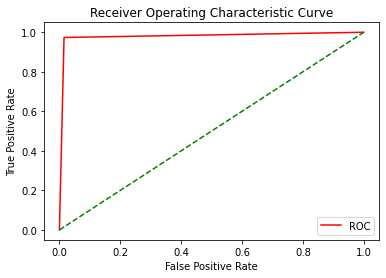

In [12]:
import  matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fper, tper, thresholds = roc_curve(true_labels,best_acc_pred)
plot_roc_curve(fper, tper)